In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# Load the datasets
train_features = pd.read_csv('/training_set_features.csv')
train_labels = pd.read_csv('/training_set_labels.csv')
test_features = pd.read_csv('/test_set_features.csv')

In [5]:
# Merge train_features and train_labels on respondent_id
train_data = pd.merge(train_features, train_labels, on='respondent_id')

In [ ]:
train_data.head()

,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [6]:
# Identify feature columns and target columns
feature_columns = train_features.columns[1:]    # Exclude respondent_id
vaccine_target_column = 'xyz_vaccine'
flu_target_column = 'seasonal_vaccine'

In [7]:
# Preprocess the data
# Separate numerical, categorical and text columns
numerical_cols = [col for col in feature_columns if train_data[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in feature_columns if train_data[col].dtype == 'object']
# Assume text columns are categorical for simplicity
text_cols = []
# If any text columns exist, you can handle them separately or treat as categorical

In [8]:
# Imputation transformers
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols + text_cols)
    ])

In [10]:
# Define the model for vaccine
vaccine_model = RandomForestClassifier(n_estimators=100, random_state=0)
vaccine_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', vaccine_model)
])

In [11]:
# Define the model for flu
flu_model = RandomForestClassifier(n_estimators=100, random_state=0)
flu_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', flu_model)
])

In [12]:
# Separate features and targets
X = train_data[feature_columns]
y_vaccine = train_data['xyz_vaccine']
y_flu = train_data['seasonal_vaccine']

In [13]:
# Fit the models
vaccine_clf.fit(X, y_vaccine)
flu_clf.fit(X, y_flu)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['xyz_concern',
                                                   'xyz_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_xyz',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [14]:
# Split data into training and validation sets
X_train_vaccine, X_val_vaccine, y_train_vaccine, y_val_vaccine = train_test_split(X, y_vaccine, test_size=0.2, random_state=0)
X_train_flu, X_val_flu, y_train_flu, y_val_flu = train_test_split(X, y_flu, test_size=0.2, random_state=0)

In [15]:
# Predict probabilities on the validation set
vaccine_val_probabilities = vaccine_clf.predict_proba(X_val_vaccine)[:, 1]  # Probability of the positive class
flu_val_probabilities = flu_clf.predict_proba(X_val_flu)[:, 1]  # Probability of the positive class

Vaccine ROC AUC: 1.0
Flu ROC AUC: 1.0


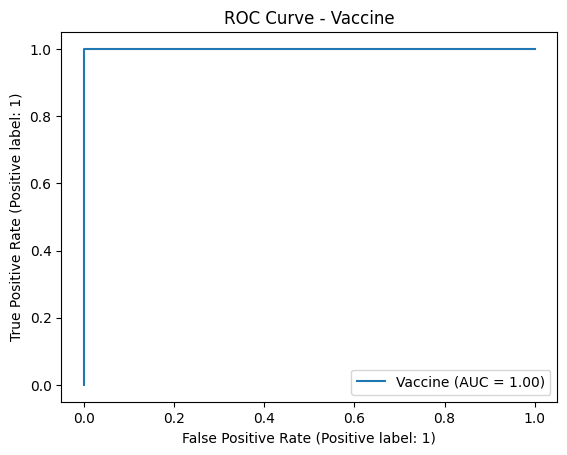

In [17]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Calculate ROC AUC scores
vaccine_roc_auc = roc_auc_score(y_val_vaccine, vaccine_val_probabilities)
flu_roc_auc = roc_auc_score(y_val_flu, flu_val_probabilities)

print(f'Vaccine ROC AUC: {vaccine_roc_auc}')
print(f'Flu ROC AUC: {flu_roc_auc}')

import matplotlib.pyplot as plt

# Plot ROC curves
RocCurveDisplay.from_estimator(vaccine_clf, X_val_vaccine, y_val_vaccine, name="Vaccine")
plt.title('ROC Curve - Vaccine')
plt.show()

In [27]:
# Create a DataFrame for the predictions
submission = pd.DataFrame({
'respondent_id': test_features['respondent_id'],
    'vaccine_probability': vaccine_clf.predict_proba(test_features)[:, 1]
}),
if 'flu_probabilities' not in globals():
    print("Variable 'flu_probabilities' is not defined.")

import numpy as np

# Create a DataFrame for the predictions
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'vaccine_probability': vaccine_clf.predict_proba(test_features)[:, 1]
})

# Convert the submission tuple to a 2-dimensional array
submission = np.array(submission)

# Create a DataFrame from the array
submission = pd.DataFrame(submission)

# Save the predictions to a CSV file
submission.to_csv('test_labels_predictions.csv', index=False)

Variable 'flu_probabilities' is not defined.


**Using vectorization**

In [28]:
X = train_data.drop(['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'], axis=1)
y_xyz_vaccine = train_data['xyz_vaccine']
y_seasonal_vaccine = train_data['seasonal_vaccine']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_xyz_vaccine, test_size=0.2, random_state=42)


In [30]:
columns_to_vectorize = ['hhs_geo_region','employment_industry', 'employment_occupation']

In [31]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

In [32]:
columns_to_vectorize = ['hhs_geo_region', 'employment_industry', 'employment_occupation']
vectorizer = TfidfVectorizer()

vectorized_columns = []
for col in columns_to_vectorize:
    # Fit and transform the text data in the current column
    vectorized_data = vectorizer.fit_transform(X_train[col].astype(str))

    # Convert the sparse matrix to a DataFrame
    vectorized_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())

    # Add prefix to column names to indicate original column
    vectorized_df.columns = [col + '_' + word for word in vectorized_df.columns]

    # Append to list of vectorized columns
    vectorized_columns.append(vectorized_df)

# Concatenate vectorized columns with X_train DataFrame
X_train = pd.concat([X_train.reset_index(drop=True)] + vectorized_columns, axis=1)


In [33]:
X_train

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21360,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21361,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21362,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21363,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Load your dataset
train_features = pd.read_csv('/training_set_features.csv')

# Example categorical columns
categorical_cols = ['age_group', 'education', 'race', 'sex', 'income_poverty',
                    'marital_status', 'rent_or_own', 'employment_status', 'census_msa']

# Select categorical columns from the dataset
X_categorical = train_features[categorical_cols]

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)

# Fit and transform the categorical columns
X_encoded = encoder.fit_transform(X_categorical)

# Create a DataFrame with the encoded categorical columns
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate encoded categorical columns with original dataset
train_features_encoded = pd.concat([train_features, encoded_df], axis=1)

# Display the updated dataset with encoded columns
print(train_features_encoded.head())


   respondent_id  xyz_concern  xyz_knowledge  behavioral_antiviral_meds  \
0              0          1.0            0.0                        0.0   
1              1          3.0            2.0                        0.0   
2              2          1.0            1.0                        0.0   
3              3          1.0            1.0                        0.0   
4              4          2.0            1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0  

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [42]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your dataset
train_features = pd.read_csv('/training_set_features.csv')

# Example text columns
text_cols = ['hhs_geo_region', 'employment_industry', 'employment_occupation']

# Select text columns from the dataset
X_text = train_features[text_cols].astype(str)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text columns
X_vectorized = vectorizer.fit_transform(X_text.apply(lambda x: ' '.join(x), axis=1))

# Create a DataFrame with the vectorized text columns
vectorized_df = pd.DataFrame(X_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate vectorized text columns with original dataset
train_features_vectorized = pd.concat([train_features, vectorized_df], axis=1)

# Display the updated dataset with vectorized columns
print(train_features_vectorized.head())

   respondent_id  xyz_concern  xyz_knowledge  behavioral_antiviral_meds  \
0              0          1.0            0.0                        0.0   
1              1          3.0            2.0                        0.0   
2              2          1.0            1.0                        0.0   
3              3          1.0            1.0                        0.0   
4              4          2.0            1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0  